In [22]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import pickle

In [23]:

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()


        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(11, 11))
        plt.gray()


    plt.show()



def display_input_comp(array1, array2,array3):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2,image3) in enumerate(zip(images1, images2, images3)):

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(18, 18))
        plt.gray()


        ax = plt.subplot(3, n,  i+1+n + n)
        plt.imshow(image3.reshape(18, 18))
        plt.gray()


    plt.show()

In [24]:
def pixalate_image(image, scale_percent = 40):
  """
    Makes Low Resolution image from supplied image. Reduces height and width by 'scale_percent' percent.

  """
  width = int(18)
  height = int(18)
  dim = (width, height)
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


  return small_image

In [25]:

(train_data, _), (test_data, _) = mnist.load_data()

# Normalize
train_data = preprocess(train_data)
test_data = preprocess(test_data)


# Make low Resolution
small_img_train = np.empty(shape=(train_data.shape[0],18,18))
small_img_test = np.empty(shape=(test_data.shape[0],18,18))

for i in range (len(train_data)):
  small_img_train[i]= pixalate_image(train_data[i])

for i in range (len(test_data)):
  small_img_test[i]= pixalate_image(test_data[i]) 



In [26]:
small_img_train[0].shape

(18, 18)

In [27]:
#Add dummy dimension so that Conv can work with it
small_img_train=small_img_train[...,None]

In [28]:
small_img_test=small_img_test[...,None]

In [29]:
#shape
small_img_train[0].shape

(18, 18, 1)

In [30]:

# Add Noise to the low resolution image
noisy_train_data = noise(small_img_train)
noisy_test_data = noise(small_img_test)


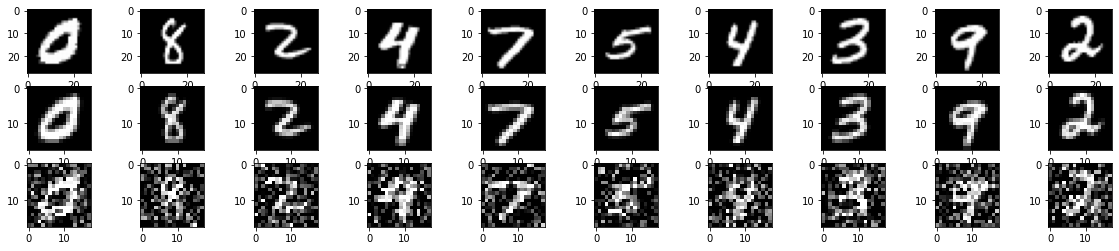

In [31]:
#Display original image, low res. image, and noisy low res image
display_input_comp(train_data,small_img_train,noisy_train_data)

In [32]:
test_data.shape[0]

10000

In [33]:
from keras import Sequential, optimizers
from keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional,ConvLSTM2D,GRU,SimpleRNN,RNN
from keras import regularizers
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D,MaxPooling1D, Conv2D , MaxPooling2D, Conv2DTranspose
from keras import regularizers
from tensorflow import keras

model = Sequential()

# Encoder
model.add((Conv2D(filters=64, kernel_size=3, input_shape=(18, 18, 1),activation='relu', padding='same')))
model.add(Conv2D(32, 3, activation='relu',))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu",))
model.add(MaxPooling2D((2, 2), padding="same"))

#Decoder
model.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2DTranspose(32, (3, 3), strides=3, activation="relu", padding="same"))
model.add(Conv2D(32, 5, activation="relu"))
model.add(Conv2D(1, 5, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['acc'])

In [34]:
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 18, 18, 64)        640       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 12, 12, 32)       

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)


In [36]:
history = model.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=64,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
938/938 [==============================] - 15s 8ms/step - loss: 0.2582 - acc: 0.7962 - val_loss: 0.1653 - val_acc: 0.8030
Epoch 2/100
938/938 [==============================] - 7s 8ms/step - loss: 0.1643 - acc: 0.8026 - val_loss: 0.1542 - val_acc: 0.8029
Epoch 3/100
938/938 [==============================] - 7s 8ms/step - loss: 0.1548 - acc: 0.8046 - val_loss: 0.1487 - val_acc: 0.8033
Epoch 4/100
938/938 [==============================] - 7s 8ms/step - loss: 0.1509 - acc: 0.8051 - val_loss: 0.1471 - val_acc: 0.8066
Epoch 5/100
938/938 [==============================] - 7s 8ms/step - loss: 0.1481 - acc: 0.8057 - val_loss: 0.1452 - val_acc: 0.8043
Epoch 6/100
938/938 [==============================] - 7s 8ms/step - loss: 0.1457 - acc: 0.8065 - val_loss: 0.1434 - val_acc: 0.8053
Epoch 7/100
938/938 [==============================] - 8s 8ms/step - loss: 0.1451 - acc: 0.8061 - val_loss: 0.1467 - val_acc: 0.8076
Epoch 8/100
938/938 [==============================] - 7s 8ms/step -

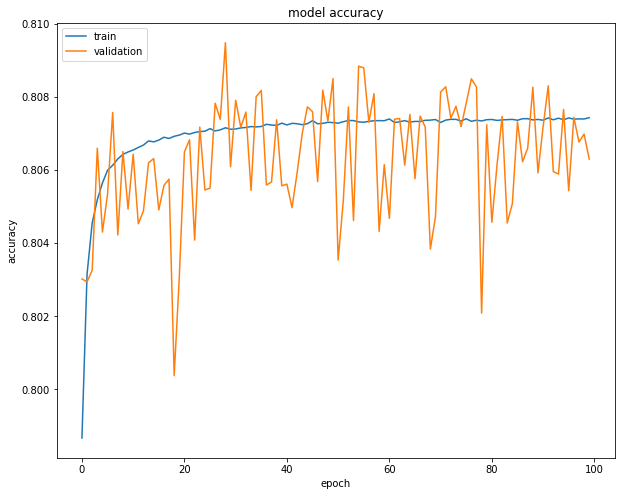

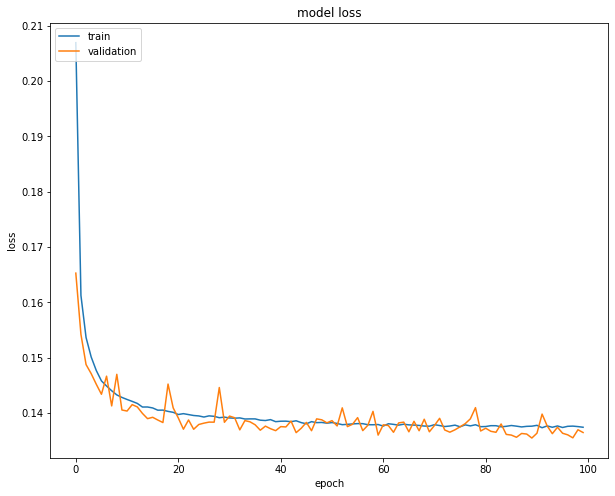

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')

plt.show()

In [38]:
def display_res(array1, array2):
    """
    To compare Result: array1=Input image, array2=Output Image
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(18, 18))
        plt.gray()


        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()


    plt.show()


def display_res_test(array1, array2):
    """
    To Compare Original (28,28) with Predicted (28,28) 
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()


        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()


    plt.show()




def display_comp(array1, array2,array3):
    """
    To compare Result: array1=Low res image, array2=Low res noisy Image (input)
                       array3 = High res Denoised Image (Output)

    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2,image3) in enumerate(zip(images1, images2, images3)):

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(18, 18))
        plt.gray()

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(18, 18))
        plt.gray()


        ax = plt.subplot(3, n,  i+1+n + n)
        plt.imshow(image3.reshape(28, 28))
        plt.gray()


    plt.show()

In [48]:
predictions = model.predict(noisy_test_data)


# display_res_test(test_data, predictions)


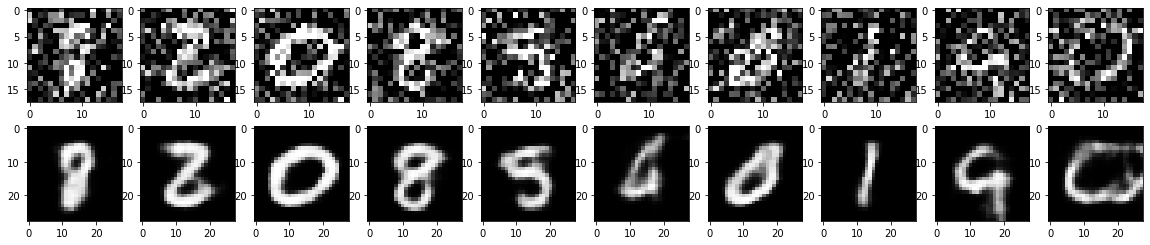

In [49]:
display_res(noisy_test_data, predictions)

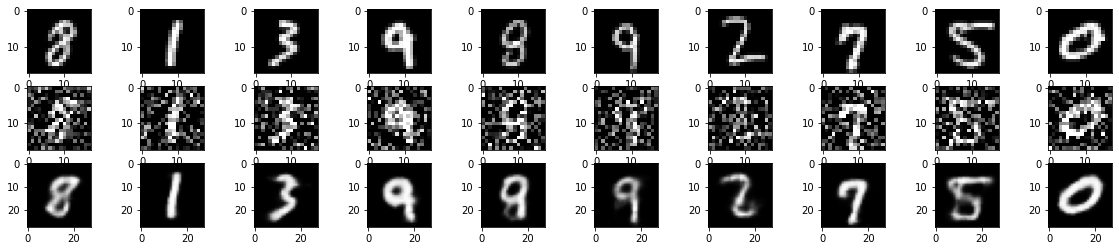

In [50]:
display_comp(small_img_test, noisy_test_data,predictions)

# First Row ---> Low Resolution Image
# Second Row ---> Low Resolution Noisy Image (Input image)
# Third Row --->  Denoised Super Resoluted image (Output Image)

In [54]:
from keras import models

In [57]:
model.save('saved_model')

In [58]:
saved_model=models.load_model('saved_model')

In [59]:
saved_model.predict(noisy_test_data)

array([[[[5.72857733e-13],
         [8.24707923e-12],
         [2.62115538e-08],
         ...,
         [3.86007359e-09],
         [2.49394787e-07],
         [7.21525566e-07]],

        [[2.63161834e-13],
         [3.00182340e-12],
         [3.00470475e-08],
         ...,
         [2.26697927e-09],
         [1.80113116e-08],
         [7.00893068e-08]],

        [[5.57445539e-12],
         [1.02358165e-11],
         [4.02003231e-09],
         ...,
         [3.12954604e-08],
         [1.81655295e-08],
         [5.82472239e-08]],

        ...,

        [[1.91998461e-05],
         [5.95365736e-06],
         [1.80301085e-05],
         ...,
         [5.77190860e-07],
         [3.37663863e-07],
         [1.07934432e-06]],

        [[6.72842043e-06],
         [3.93411437e-06],
         [8.46709554e-06],
         ...,
         [3.91152241e-07],
         [1.83553510e-07],
         [6.65375410e-07]],

        [[1.06936732e-05],
         [1.56202768e-05],
         [3.26214395e-05],
         ...,
 